In [1]:
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter


## Import Data

In [3]:
df = pd.read_csv('sales_history.csv')

In [4]:
df = df.drop('Unnamed: 0', axis=1)

In [5]:
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [6]:
numeric_columns = ['AveragePrice', 'Total Volume','4046', '4225', '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']
categorical_columns = ['Region', 'Type']
time_columns = ['Date', 'Year']

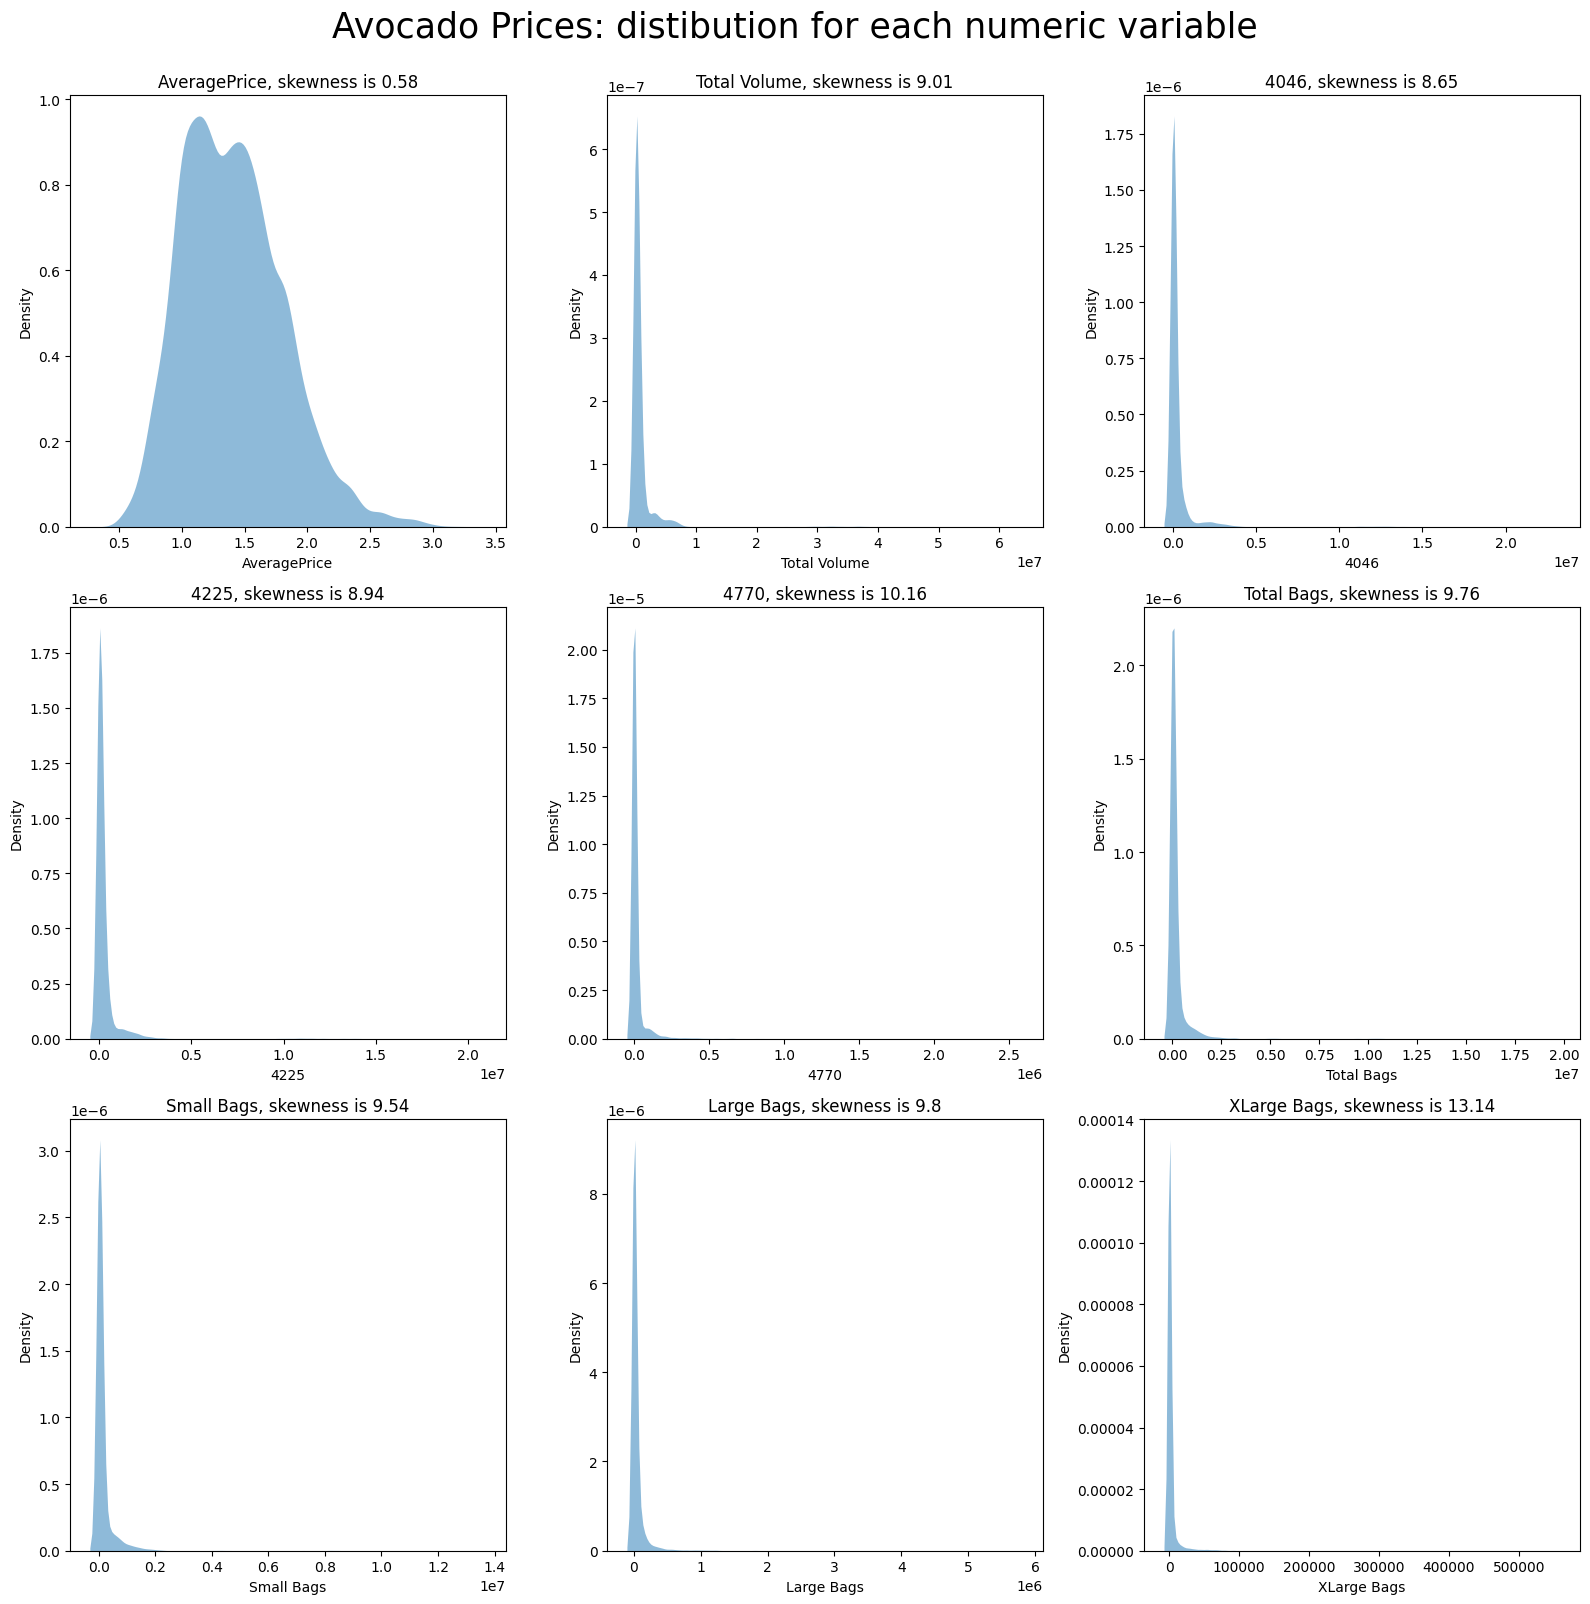

In [7]:
# Checking for distributions
def dist_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, figsize=(16,16))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.kdeplot(dataset[data], ax=axs[i], fill=True,  alpha=.5, linewidth=0)
        axs[i].set_title(data + ', skewness is '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))

dist_custom(
    dataset=df, 
    columns_list=numeric_columns, 
    rows=3, cols=3, 
    suptitle='Avocado Prices: distibution for each numeric variable'
)
plt.tight_layout()

# 5. Data pre-processing

## Some transformations

In [8]:
# Changing data types
for i in df.columns:
    if i == 'Date':
        df[i] = df[i].astype('datetime64[ns]')
    elif df[i].dtype == 'object':
        df[i] = df[i].astype('category')

In [9]:
df_c1 = df.copy()

df_c1['Date'] = pd.to_datetime(df_c1['Date'])
df_c1['month'] = df_c1['Date'].dt.month

df_c1['Spring'] = df_c1['month'].between(3,5,inclusive='both')
df_c1['Summer'] = df_c1['month'].between(6,8,inclusive='both')
df_c1['Fall'] = df_c1['month'].between(9,11,inclusive='both')

# Changes here ...
df_c1['Winter'] = df_c1['month'].between(1,2,inclusive='both')
df_c1.loc[(df_c1.month == 12), 'Winter'] = True


df_c1.Spring = df_c1.Spring.replace({True: 1, False: 0})
df_c1.Summer = df_c1.Summer.replace({True: 1, False: 0})
df_c1.Fall = df_c1.Fall.replace({True: 1, False: 0})
df_c1.Winter = df_c1.Winter.replace({True: 1, False: 0})

df_c1

C:\Users\nisua\AppData\Local\Temp\ipykernel_17860\2120207479.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_c1.Spring = df_c1.Spring.replace({True: 1, False: 0})
C:\Users\nisua\AppData\Local\Temp\ipykernel_17860\2120207479.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_c1.Summer = df_c1.Summer.replace({True: 1, False: 0})
C:\Users\nisua\AppData\Local\Temp\ipykernel_17860\2120207479.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old beha

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,month,Spring,Summer,Fall,Winter
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,12,0,0,0,1
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,12,0,0,0,1
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,12,0,0,0,1
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,12,0,0,0,1
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,11,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico,2,0,0,0,1
18245,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico,1,0,0,0,1
18246,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico,1,0,0,0,1
18247,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico,1,0,0,0,1


In [10]:
df_c1.columns

Index(['Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year',
       'region', 'month', 'Spring', 'Summer', 'Fall', 'Winter'],
      dtype='object')

In [11]:
# Encoding labels for 'type'
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_c1['type'] = le.fit_transform(df_c1['type'])

# Encoding 'region' (One Hot Encoding)
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
ohe = pd.get_dummies(df_c1, columns=['region'], dtype=int)

df_c1 = ohe.drop(['Date','4046','4225','4770','Small Bags','Large Bags','XLarge Bags'], axis=1)

In [12]:
df_c1

,AveragePrice,Total Volume,Total Bags,type,year,month,Spring,Summer,Fall,Winter,...,region_SouthCarolina,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico
0,1.33,64236.62,8696.87,0,2015,12,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1.35,54876.98,9505.56,0,2015,12,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0.93,118220.22,8145.35,0,2015,12,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1.08,78992.15,5811.16,0,2015,12,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1.28,51039.60,6183.95,0,2015,11,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,1.63,17074.83,13498.67,1,2018,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
18245,1.71,13888.04,9264.84,1,2018,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
18246,1.87,13766.76,9394.11,1,2018,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
18247,1.93,16205.22,10969.54,1,2018,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


## Outlier detection and removal

In [13]:
df_c1.shape

(18249, 64)

In [14]:
def IQR_method (df, n, features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
        Q1 = np.percentile(df[column], 25) # 1st quartile (25%)
        Q3 = np.percentile(df[column],75) # 3rd quartile (75%)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR # Range of Acceptance
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index  # Determining a list of indices of outliers
        
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] < Q1 - outlier_step]
    df2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of deleted outliers:', df1.shape[0]+df2.shape[0])
    
    return multiple_outliers

In [15]:
outlier_dec_col_avacardo = ['Total Volume', 'Total Bags']
outliers_IQR = IQR_method(df_c1, n=1, features=outlier_dec_col_avacardo)

# dropping outliers
df_c1_2 = df_c1.drop(outliers_IQR, axis = 0).reset_index(drop=True)

Total number of deleted outliers: 2533


In [16]:
df_c1_2

,AveragePrice,Total Volume,Total Bags,type,year,month,Spring,Summer,Fall,Winter,...,region_SouthCarolina,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico
0,1.33,64236.62,8696.87,0,2015,12,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1.35,54876.98,9505.56,0,2015,12,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0.93,118220.22,8145.35,0,2015,12,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1.08,78992.15,5811.16,0,2015,12,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1.28,51039.60,6183.95,0,2015,11,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16163,1.63,17074.83,13498.67,1,2018,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
16164,1.71,13888.04,9264.84,1,2018,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
16165,1.87,13766.76,9394.11,1,2018,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
16166,1.93,16205.22,10969.54,1,2018,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


# Train Test Split

In [17]:
df_c1_2.columns

Index(['AveragePrice', 'Total Volume', 'Total Bags', 'type', 'year', 'month',
       'Spring', 'Summer', 'Fall', 'Winter', 'region_Albany', 'region_Atlanta',
       'region_BaltimoreWashington', 'region_Boise', 'region_Boston',
       'region_BuffaloRochester', 'region_California', 'region_Charlotte',
       'region_Chicago', 'region_CincinnatiDayton', 'region_Columbus',
       'region_DallasFtWorth', 'region_Denver', 'region_Detroit',
       'region_GrandRapids', 'region_GreatLakes', 'region_HarrisburgScranton',
       'region_HartfordSpringfield', 'region_Houston', 'region_Indianapolis',
       'region_Jacksonville', 'region_LasVegas', 'region_LosAngeles',
       'region_Louisville', 'region_MiamiFtLauderdale', 'region_Midsouth',
       'region_Nashville', 'region_NewOrleansMobile', 'region_NewYork',
       'region_Northeast', 'region_NorthernNewEngland', 'region_Orlando',
       'region_Philadelphia', 'region_PhoenixTucson', 'region_Pittsburgh',
       'region_Plains', 'region_Portl

In [18]:
# avacardo
X_df = df_c1_2.drop('AveragePrice', axis=1)
y_df = df_c1_2['AveragePrice']

In [19]:
from sklearn.model_selection import train_test_split
X_df_train, X_df_test, y_df_train, y_df_test = train_test_split(X_df, y_df, test_size=0.3, random_state=24)

## Feature Scaling

In [20]:
from sklearn.preprocessing import StandardScaler

# Creating a function for Scaling the Values.
def Standard_Scaler (df, col_name):
    features = df[col_name]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_name] = features

    return df

In [21]:
col_name = ['Total Volume', 'Total Bags']
X_ava_train = Standard_Scaler(X_df_train, col_name=col_name)
X_ava_test = Standard_Scaler(X_df_test, col_name=col_name)